## Targeted Classifier Experiment


"Utilizing BERT for TABSA via auxiliary sentences"
https://aclanthology.org/N19-1035.pdf


In [2]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [3]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

def build_pos_sentence(target):
    return f"La opinión de {target} es positiva"

def build_neg_sentence(target):
    return f"La opinión de {target} es positiva"

def build_neu_sentence(target):
    return f"La opinión sobre {target} es neutra"

auxiliary_sentence_fun = {
    "POS": build_pos_sentence,
    "NEG": build_neg_sentence,
    "NEU": build_neu_sentence,
}

def build_df(data):
    rows = []
    for row in data:
        for (target, label) in row["labels"].items():
            for other_label in label2id.keys():
                rows.append({
                    "id": row["id"],
                    "sentence": row["titulo"],
                    "target": target,
                    "auxiliary_sentence": auxiliary_sentence_fun[other_label](target),
                    "label": int(other_label == label),
                })
    return pd.DataFrame(rows)

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=2021, stratify=[len(x["labels"]) for x in data])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=[len(x["labels"]) for x in train_data])

len(train_data), len(dev_data), len(test_data)

(1085, 362, 483)

## Armar dataset

In [5]:
from datasets import Dataset, Value, ClassLabel, Features

train_df = build_df(train_data)
dev_df = build_df(dev_data)
test_df = build_df(test_data)

features = Features({
    'sentence': Value('string'),
    'auxiliary_sentence': Value('string'),
    'label': ClassLabel(num_classes=2, names=["no", "yes"])
})

columns = ["sentence", "auxiliary_sentence", "label"]

train_dataset = Dataset.from_pandas(train_df[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_df[columns], features=features)
test_dataset = Dataset.from_pandas(test_df[columns], features=features)

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=2
)

#model.config.id2label = id2label
#model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [8]:
def tokenize(batch):
    return tokenizer(batch['sentence'], batch['auxiliary_sentence'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 51., 337., 866., 910., 997., 512., 207.,  92.,  25.,  11.]),
 array([15. , 18.7, 22.4, 26.1, 29.8, 33.5, 37.2, 40.9, 44.6, 48.3, 52. ]),
 <BarContainer object of 10 artists>)

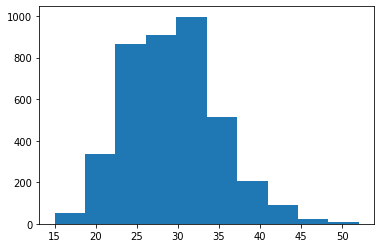

In [9]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [10]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [11]:
train_df

,id,sentence,target,auxiliary_sentence,label
0,15329,Luli Salazar fulminó a Mauricio Macri por su p...,Mauricio Macri,La opinión de Mauricio Macri es positiva,1
1,15329,Luli Salazar fulminó a Mauricio Macri por su p...,Mauricio Macri,La opinión sobre Mauricio Macri es neutra,0
2,15329,Luli Salazar fulminó a Mauricio Macri por su p...,Mauricio Macri,La opinión de Mauricio Macri es positiva,0
3,6005,Mauricio Macri homenajeó a soldados asesinados...,Mauricio Macri,La opinión de Mauricio Macri es positiva,0
4,6005,Mauricio Macri homenajeó a soldados asesinados...,Mauricio Macri,La opinión sobre Mauricio Macri es neutra,0
...,...,...,...,...,...
4003,8322,"Mauricio Macri, contra Kicillof: “Digan los di...",Mauricio Macri,La opinión sobre Mauricio Macri es neutra,0
4004,8322,"Mauricio Macri, contra Kicillof: “Digan los di...",Mauricio Macri,La opinión de Mauricio Macri es positiva,1
4005,14320,"Para los medios, Del Caño fue uno de los que m...",Del Caño,La opinión de Del Caño es positiva,0
4006,14320,"Para los medios, Del Caño fue uno de los que m...",Del Caño,La opinión sobre Del Caño es neutra,0


In [12]:
from transformers import TrainingArguments, Trainer
from torch.nn import functional as F
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    ret = {}
    labels = pred.label_ids
    preds = pred.predictions
    # No sé xq tengo que convertir en tensor y no viene directo así
    ret["loss"] = F.cross_entropy(torch.tensor(preds), torch.tensor(labels))
    ret["acc"] = accuracy_score(labels, preds.argmax(1))
    precision, recall, fscore, _ = precision_recall_fscore_support(labels, preds.argmax(1),  average="binary")

    ret["precision"] = precision
    ret["recall"] = recall
    ret["f1"] = fscore 

    return ret

epochs = 20
warmup_proportion = 0.05
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    learning_rate=3e-5,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc,Precision,Recall,F1,Runtime,Samples Per Second
1,No log,0.639083,0.666667,0.000000,0.000000,0.000000,6.603200,202.175000
2,0.644100,0.646403,0.666667,0.000000,0.000000,0.000000,6.578900,202.920000
3,0.644100,0.622825,0.666667,0.000000,0.000000,0.000000,6.564500,203.367000
4,0.594000,0.585573,0.701124,0.794872,0.139326,0.237094,6.593000,202.489000
5,0.594000,0.761823,0.615730,0.447531,0.651685,0.530650,6.742400,198.002000
6,0.440400,0.745458,0.576779,0.415966,0.667416,0.512511,6.601000,202.242000
7,0.440400,0.790439,0.689139,0.605634,0.193258,0.293015,6.707300,199.038000
8,0.400800,0.855013,0.683895,0.734694,0.080899,0.145749,6.702300,199.185000
9,0.400800,0.864007,0.555056,0.406524,0.728090,0.521739,6.732800,198.282000
10,0.375500,0.790565,0.591011,0.429568,0.692135,0.530120,6.676200,199.963000


/home/jmperez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmperez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmperez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=5020, training_loss=0.41159123832961003, metrics={'train_runtime': 1782.7547, 'train_samples_per_second': 2.816, 'total_flos': 6762831227043840.0, 'epoch': 20.0, 'init_mem_cpu_alloc_delta': 55263, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1692841, 'train_mem_gpu_alloc_delta': 1794108416, 'train_mem_cpu_peaked_delta': 95676487, 'train_mem_gpu_peaked_delta': 1338078720})

In [14]:
trainer.evaluate(dev_dataset)

{'eval_loss': 0.5855734348297119,
 'eval_acc': 0.701123595505618,
 'eval_precision': 0.7948717948717948,
 'eval_recall': 0.1393258426966292,
 'eval_f1': 0.23709369024856597,
 'eval_runtime': 12.3786,
 'eval_samples_per_second': 107.848,
 'epoch': 20.0,
 'eval_mem_cpu_alloc_delta': 74955,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 292068,
 'eval_mem_gpu_peaked_delta': 35185664}

In [15]:
model = trainer.model

In [16]:
sentence = "Terrible año para Messi, y grandísimo año de Cristiano Ronaldo"
target = "Cristiano Ronaldo"

batch = tokenizer([sentence] * 3, [auxiliary_sentence_fun[label](target) for label in label2id], padding="max_length", truncation=True)

batch = {k:torch.LongTensor(v).to(device) for k, v in batch.items()}

out = model(**batch)

torch.softmax(out.logits, dim=1)


tensor([[0.6806, 0.3194],
        [0.8131, 0.1869],
        [0.6806, 0.3194]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [17]:
from torch.nn import functional as F
def predict(sentence, target):
    """
    Return most likely class for the sentence
    """
    idx = torch.LongTensor(
        tokenizer.encode(sentence, auxiliary_sentence_fun["NEG"](target))).view(1, -1).to(device)
    print(tokenizer.decode(idx[0]))
    output = model(idx)
    probs = F.softmax(output.logits, dim=1).view(-1)
    probas = {id2label[i]:probs[i].item() for i in id2label}

    return probas



In [18]:
sentence = "Gran 2020 para Messi, pero bastante malo para Cristiano Ronaldo"

targets = ["Messi", "Cristiano Ronaldo"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Messi
[CLS] gran 2020 para messi, pero bastante malo para cristiano ronaldo [SEP] la opinión de messi es positiva [SEP]


IndexError: index 2 is out of bounds for dimension 0 with size 2

In [ ]:
sentence = "Alberto Fernández: \"El gobierno de Macri fue un desastre\""

targets = ["Alberto Fernández", "Macri"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "Alberto Fernández: \"El gobierno de Xi Jin Ping fue un desastre\""

targets = ["Alberto Fernández", "Xi Jin Ping"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "Romina Del Plá denunció el ajuste de Alberto Fernández"

targets = ["Romina del Plá", "Alberto Fernández"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "El Gobierno confirmó el decreto para destrabar la compra de vacunas"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "Cristina Kirchner acusa al Gobierno de corrupción en la compra de vacunas"

targets = ["Gobierno", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "El duro comunicado de las empresas estadounidenses contra el Gobierno"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "Ultiman negociaciones para cerrar acuerdo en la Ciudad entre Vidal y Bullrich"

targets = ["Vidal", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "\"Este Gobierno ha sido una lacra corrupta inmunda\" declaró Patricia Bullrich"

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Si lo ponemos adelante, sin embargo...

In [ ]:
sentence = "Patricia Bullrich: \"Este Gobierno ha sido una lacra corrupta inmunda\""

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

In [ ]:
sentence = "Keiko: 'Pedro Castillo es un pésimo dirigente, pero por suerte este Gobierno es lo mejor que le ha pasado a Perú'"

targets = ["Keiko", "Pedro Castillo", "Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))